### American University of Phnom Penh
### ITM 454 001 ~ Natural Language Processing
Instructor: Monyrath BUNTOUN

### Final Project Title: FAQ Chatbot for AUPP Website
**Proposed By:** Senghak Choeun, Y Houk, Channy Prak, Sophea Phin, Laytong Ly  
**Fall 2025 Semester**


### 1. Setup and Imports

In [2]:
import os
import re
import pandas as pd
import numpy as np
import nltk
from sklearn.utils import resample
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure NLTK resources
nltk_data = ["punkt", "wordnet", "omw-1.4", "stopwords"]
for res in nltk_data:
    try:
        nltk.data.find(f"tokenizers/{res}") if res == "punkt" else nltk.data.find(f"corpora/{res}")
    except LookupError:
        nltk.download(res)


[nltk_data] Downloading package wordnet to C:\Users\ouk
[nltk_data]     y\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\ouk
[nltk_data]     y\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### 2. Load and Explore Dataset

In [ ]:
import json
import pandas as pd
from sklearn.utils import resample
import numpy as np # Added for later use, good to include early

# Load the dataset from the JSON file
try:
    with open("dataset.json", 'r', encoding='utf-8') as f:
        data = json.load(f)
except FileNotFoundError:
    print("Error: aupp_chatbot_dataset.json not found. Please ensure the file is in the same directory.")
    raise

df = pd.DataFrame(data)

# Ensure columns exist and handle missing values
df['question'] = df['question'].fillna('').astype(str)
df['answer'] = df['answer'].fillna('').astype(str)
df['category'] = df['category'].fillna('UNKNOWN').astype(str)

print(f"Total questions loaded: {len(df)}")

# Oversample small classes to a minimum size for better training
min_size = 15 
frames = []

for label in df["category"].unique():
    block = df[df["category"] == label]
    if len(block) < min_size:
        extra = resample(block, replace=True, n_samples=min_size - len(block), random_state=42)
        frames.append(extra)

df = pd.concat([df] + frames, ignore_index=True)
print("\nBalanced classes for Intent Training:")
print(df["category"].value_counts())



Total questions loaded: 437

Balanced classes for Intent Training:
category
Academic Policies              144
University Leadership           79
Career/Faculty Info             70
Programs & Majors               48
Professional Programs           42
Tuition Fees & Scholarships     32
University Info                 22
Name: count, dtype: int64


### 3. Text Preprocessing

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)          # remove punctuation
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t.isalnum()]
    tokens = [t for t in tokens if t not in stop_words or t in {"not","no"}]  # keep negation
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df['processed_question'] = df['question'].apply(preprocess_text)




### 4. Intent Recognition Model

c:\Users\ouk y\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ouk y\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Accuracy: 0.9772727272727273
Macro F1: 0.9792008757525998
                             precision    recall  f1-score   support

          Academic Policies       0.97      0.97      0.97        29
        Career/Faculty Info       1.00      1.00      1.00        14
      Professional Programs       0.89      0.89      0.89         9
          Programs & Majors       1.00      1.00      1.00        10
Tuition Fees & Scholarships       1.00      1.00      1.00         6
            University Info       1.00      1.00      1.00         4
      University Leadership       1.00      1.00      1.00        16

                   accuracy                           0.98        88
                  macro avg       0.98      0.98      0.98        88
               weighted avg       0.98      0.98      0.98        88



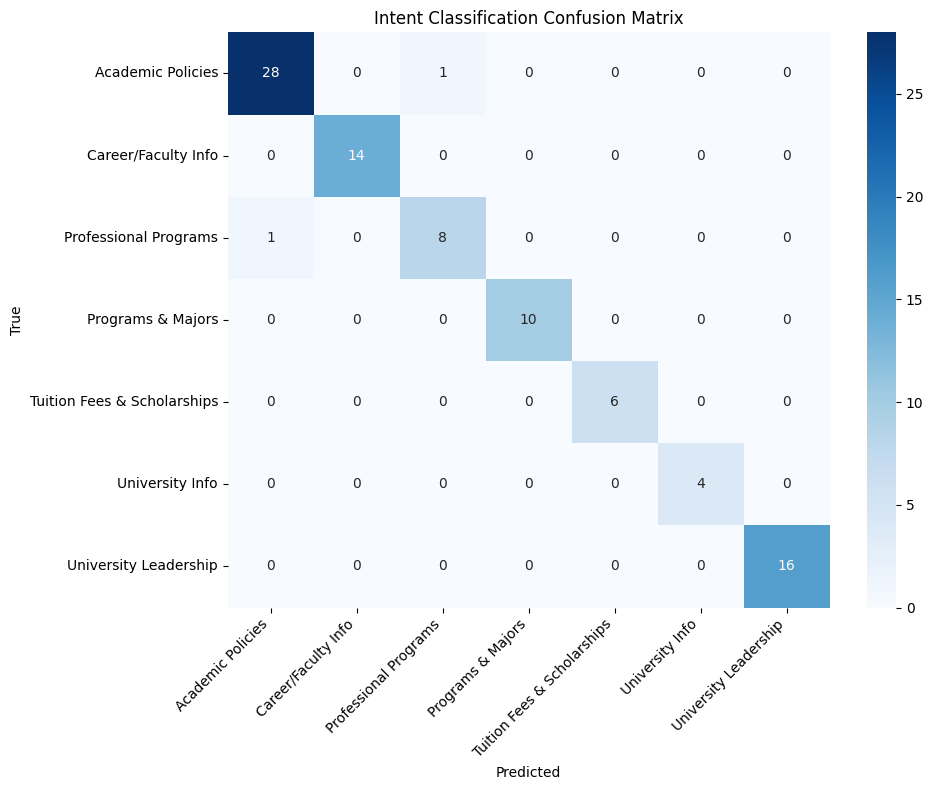

In [5]:
X = df["processed_question"].astype(str)
y = df["category"].astype(str)

# Stratify ensures equal class distribution in train/test splits.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

intent_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=1,
        max_df=0.9,
        max_features=3000
    )),
    ("clf", LogisticRegression(
        solver="liblinear",
        multi_class="ovr",
        class_weight="balanced",
        C=1.0,
        max_iter=1000
    ))
])

intent_pipeline.fit(X_train, y_train)
y_pred = intent_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred))


# Confusion matrix (plot)
labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Intent Classification Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
